In [13]:
from tensorflow.keras.models import load_model
import nibabel as nib
#from niwidgets import NiftiWidget
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [14]:
# Define constants
HOUNSFIELD_MIN = 0
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

SLICE_X = True
SLICE_Y = True
SLICE_Z = True

IMAGE_HEIGHT = 384
IMAGE_WIDTH =384
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [15]:
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN)/HOUNSFIELD_RANGE

In [16]:
import os
model = load_model('C:/RIB/code/code_final/UNET-0_2000_z20dataagumentation_384_384.h5')

In [17]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [19]:
targetName = 'RibFrac549-image'
targetNames='RibFrac549-rib-seg'
targetImagePath = f'C:/RIB/Ribfrac/test/{targetName}.nii'
targetMaskPath  = f'C:/RIB/Ribseg/test/{targetNames}.nii'

imgTargetNii = nib.load(targetImagePath)
imgMaskNii = nib.load(targetMaskPath)

imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())
imgMask = imgMaskNii.get_fdata()

In [20]:
sliceIndex = 320

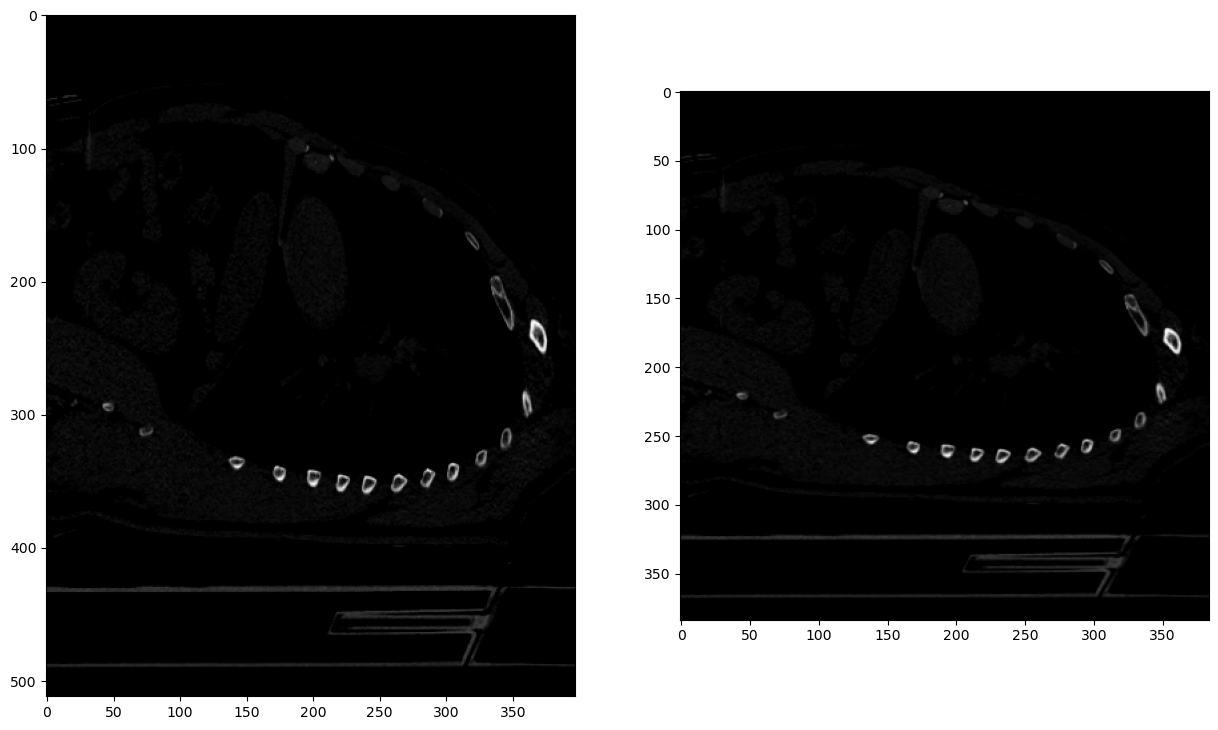

((512, 397), (384, 384))

In [21]:
# show input image slice
plt.figure(figsize=(15,15))
imgSlice = imgTarget[sliceIndex,:,:]
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(imgSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgSliceScaled, cmap='gray')
plt.show()
imgSlice.shape, imgSliceScaled.shape

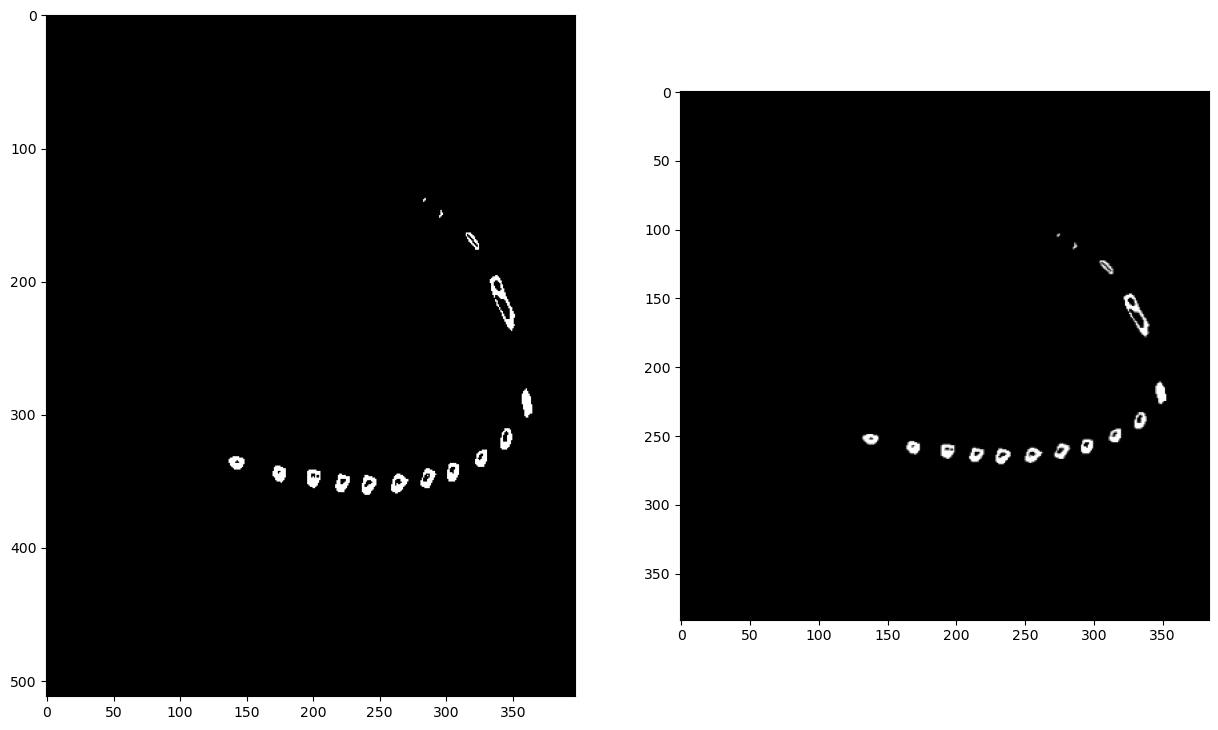

((512, 397), (384, 384))

In [22]:
# show input mask slice
plt.figure(figsize=(15,15))
maskSlice = imgMask[sliceIndex,:,:]
maskSliceScaled = scaleImg(maskSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(maskSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(maskSliceScaled, cmap='gray')
plt.show()
maskSlice.shape, maskSliceScaled.shape

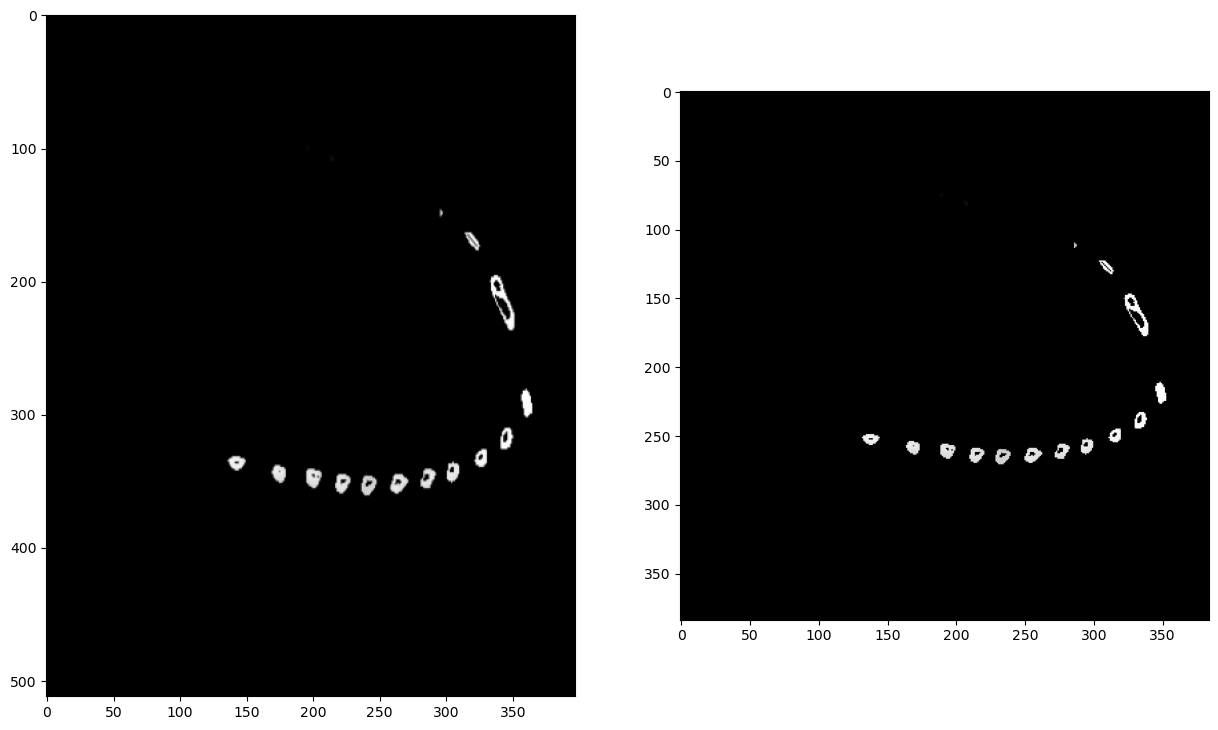

((512, 397), (384, 384))

In [23]:
# Predict with UNET model
plt.figure(figsize=(15,15))
imageInput = imgSliceScaled[np.newaxis,:,:,np.newaxis]
maskPredict = model.predict(imageInput)[0,:,:,0]
maskPredictScaled = scaleImg(maskPredict, imgDimX, imgDimY)
plt.subplot(1,2,2)
plt.imshow(maskPredict, cmap='gray')
plt.subplot(1,2,1)
plt.imshow(maskPredictScaled, cmap='gray')
plt.show()
maskPredictScaled.shape, maskPredict.shape

In [24]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape
    
    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))
    
    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
            
    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [25]:
import os

# 이미지 파일 경로 리스트 생성
img_dir = 'C:/RIB/Ribfrac/test_2'
img_files = os.listdir(img_dir)
img_paths = [os.path.join(img_dir, f) for f in img_files]

# 예측 결과를 저장할 디렉토리 생성
out_dir = 'C:/RIB/prediction_0_2000_z20_384test_2/'
os.makedirs(out_dir, exist_ok=True)

# 반복문을 사용하여 각 이미지 예측 결과 저장
for img_path in img_paths:
    # 이미지 로드 및 전처리
    img_nii = nib.load(img_path)
    img = normalizeImageIntensityRange(img_nii.get_fdata())

    # 예측 수행
    pred = predictVolume(img)

    # 예측 결과 저장
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    out_path = os.path.join(out_dir, f'{img_name}_pred.nii')
    nii_image = nib.Nifti1Image(pred, affine=np.eye(4))
    nib.save(nii_image, out_path)